**Model for irony detection**

# libraries

In [1]:
# ## data libraries

# standard library for data manipulation
import pandas as pd
# pretrained language model library
from sentence_transformers import SentenceTransformer
# mathematic library
import numpy as np
# times processes
from tqdm.notebook import tqdm
# vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# spliting data into test and train
from sklearn.model_selection import train_test_split
# labelencoder encodes text-labels to numbers
from sklearn.preprocessing import LabelEncoder
# library for regular expressions
import re
# library to save objects
import pickle

# ## model libraries

# classification model
from sklearn.svm import LinearSVC
# regression model
from sklearn.linear_model import LogisticRegression
# metrics for evaluation
from sklearn.metrics import confusion_matrix, classification_report
# graphic library
import seaborn as sns

# data exploration

## import DataFrame

In [2]:
df = pd.read_csv("../data/1_raw/data.csv")

## show table

In [3]:
df.head()  # just df would also work, but then the output can be way bigger

,tweets,class
0,"Fav moment in Sepp Blatter vid (0:20): ""We hav...",irony
1,Just found this while walking my human.... #ir...,irony
2,'Disrespected the wife of Prophet' - pseudo li...,irony
3,Do you know that super yeay satisfying feeling...,irony
4,If you're going to call someone ignorant and s...,irony


## general information about a DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43459 entries, 0 to 43458
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  43459 non-null  object
 1   class   43459 non-null  object
dtypes: object(2)
memory usage: 679.2+ KB


In [5]:
# df.describe() makes only sense for numeric data
df.describe()

,tweets,class
count,43459,43459
unique,43413,2
top,$$$=&gt;&gt; #peace #love #freedom\n#fight for...,irony
freq,14,23005


## look into specific row

In [6]:
df.iloc[0]["tweets"]

'Fav moment in Sepp Blatter vid (0:20): "We have to clean here first. This has nothing to do with football." https://t.co/4dhWOK9x2e #irony'

In [7]:
df.iloc[0]["class"]

'irony'

--> hashtags are a problem because they reveal the class

## number of null values per column

In [8]:
df.isnull().sum()

tweets    0
class     0
dtype: int64

## number of duplicated rows

In [9]:
df.duplicated().sum()

46

## balance of target column

### number of rows per unique value

In [10]:
df["class"].value_counts()

irony      23005
regular    20454
Name: class, dtype: int64

### graphic

<AxesSubplot:>

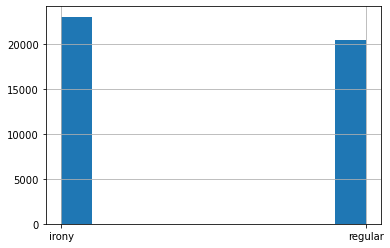

In [11]:
df["class"].hist()

# data preprocessing

## delete NaN rows

In [12]:
df = df[df["tweets"].notna()]
df = df[df["class"].notna()]

## delete duplicated rows

In [13]:
df = df.drop_duplicates()

## filtering hashtags and urls with regular expressions

In [14]:
def clean_text(txt):
    txt = str(txt).lower()
    txt = re.sub("#\w+", " ", txt)
    txt = re.sub("((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", " ", txt)
    txt = txt.strip()  # removes double whitespaces
    return txt

In [15]:
df["tweets_clean"] = df["tweets"].apply(clean_text)

## encode the class labels

In [16]:
le = LabelEncoder()
df["class_encoded"] = le.fit_transform(df["class"])

## splitting data into train and test data

In [17]:
X = df["tweets_clean"]
y = df["class_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)  # train-test-relation is 80:20

## convert tweets into vectors

### approach 1: Count vectorizer

In [18]:
cv = CountVectorizer(max_features=3000)

X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()

### approach 2: Tfidf vectorizer

In [19]:
tfidf = TfidfVectorizer(max_features=3000)

X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

### approach 3: using pretrained language model to build embeddings [takes really long!!!]

In [20]:
def build_embeddings(data):
    language_model = SentenceTransformer("quora-distilbert-multilingual")
    # Embedding creation
    print("- creating embeddings")
    message_embeddings = [language_model.encode(str(i)) for i in tqdm(data)]
    ar = np.asarray(message_embeddings)
    df_BERT = pd.DataFrame(ar)
    print("- embeddings created")

    return df_BERT

In [21]:
# takes round about 1 hour
X_train_pretrained = build_embeddings(X_train)
X_test_pretrained = build_embeddings(X_test)

- creating embeddings


  0%|          | 0/34730 [00:00<?, ?it/s]

- embeddings created
- creating embeddings


  0%|          | 0/8683 [00:00<?, ?it/s]

- embeddings created


In [22]:
# save data so that you do not have to run this all the time
# the 'index = False' is necessary because otherwise, the old indeces will be saved as a new column
X_train_pretrained.to_csv("../data/2_processed/X_train_pretrained.csv", index=False)
X_test_pretrained.to_csv("../data/2_processed/X_test_pretrained.csv", index=False)
y_train.to_csv("../data/2_processed/y_train_pretrained.csv", index=False)
y_test.to_csv("../data/2_processed/y_test_pretrained.csv", index=False)

In [23]:
# load data instead of recreating it
X_train_pretrained = pd.read_csv("../data/2_processed/X_train_pretrained.csv")
X_test_pretrained = pd.read_csv("../data/2_processed/X_test_pretrained.csv")

## end result of preprocessing

In [24]:
df

,tweets,class,tweets_clean,class_encoded
0,"Fav moment in Sepp Blatter vid (0:20): ""We hav...",irony,"fav moment in sepp blatter vid (0:20): ""we hav...",0
1,Just found this while walking my human.... #ir...,irony,just found this while walking my human....,0
2,'Disrespected the wife of Prophet' - pseudo li...,irony,'disrespected the wife of prophet' - pseudo li...,0
3,Do you know that super yeay satisfying feeling...,irony,do you know that super yeay satisfying feeling...,0
4,If you're going to call someone ignorant and s...,irony,if you're going to call someone ignorant and s...,0
...,...,...,...,...
43454,#India 'Caste war' is back as politicians woo ...,regular,'caste war' is back as politicians woo obcs: n...,1
43455,AU #education #jobs Assistant Educator - Merma...,regular,au assistant educator - mermaid waters: ql...,1
43456,"OH #GOPDebate comments: Apparently ""Jeb"" sound...",regular,"oh comments: apparently ""jeb"" sounds like “p...",1
43457,All BMC #schools to include sex #education as ...,regular,all bmc to include sex as part of the curr...,1


# train and evaluate model

## linear Support Vector Classifier

### Count Vectorizer

In [25]:
lsvc_cv = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
lsvc_cv.fit(X_train_cv, y_train)
pred_lsvc_cv = lsvc_cv.predict(X_test_cv)
print(classification_report(pred_lsvc_cv, y_test))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      4370
           1       0.76      0.72      0.74      4313

    accuracy                           0.75      8683
   macro avg       0.75      0.75      0.75      8683
weighted avg       0.75      0.75      0.75      8683



/opt/anaconda3/envs/exp/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<AxesSubplot:>

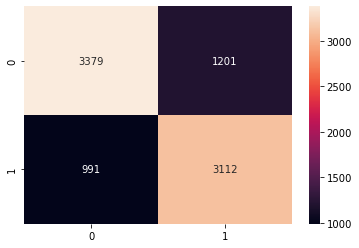

In [26]:
sns.heatmap(confusion_matrix(y_test, pred_lsvc_cv), annot=True, fmt='d')

### Tfidf vectorizer

In [27]:
lsvc_tfidf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
lsvc_tfidf.fit(X_train_tfidf, y_train)
pred_lsvc_tfidf = lsvc_tfidf.predict(X_test_tfidf)
print(classification_report(pred_lsvc_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      4656
           1       0.72      0.74      0.73      4027

    accuracy                           0.75      8683
   macro avg       0.75      0.75      0.75      8683
weighted avg       0.75      0.75      0.75      8683



<AxesSubplot:>

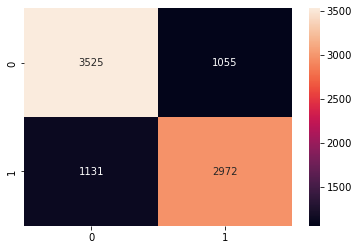

In [28]:
sns.heatmap(confusion_matrix(y_test, pred_lsvc_tfidf), annot=True, fmt='d')

### embeddings from language model

In [29]:
lsvc_pretrained = LinearSVC(random_state=0, tol=1e-5, max_iter = 1000)
lsvc_pretrained.fit(X_train_pretrained, y_train)
pred_lsvc_pretrained = lsvc_pretrained.predict(X_test_pretrained)
print(classification_report(pred_lsvc_pretrained, y_test))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      4746
           1       0.74      0.77      0.76      3937

    accuracy                           0.78      8683
   macro avg       0.77      0.78      0.77      8683
weighted avg       0.78      0.78      0.78      8683



/opt/anaconda3/envs/exp/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


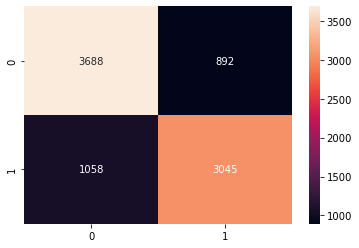

In [30]:
sns.heatmap(confusion_matrix(y_test, pred_lsvc_pretrained), annot=True, fmt='d');

## logistic regression

### Count Vectorizer

In [31]:
lr_cv = LogisticRegression(penalty="l1", solver="liblinear", random_state=0)
lr_cv.fit(X_train_cv, y_train)
pred_lr_cv = lr_cv.predict(X_test_cv)
print(classification_report(pred_lr_cv, y_test))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      4418
           1       0.76      0.73      0.75      4265

    accuracy                           0.76      8683
   macro avg       0.76      0.76      0.76      8683
weighted avg       0.76      0.76      0.76      8683



<AxesSubplot:>

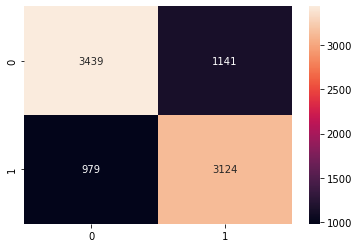

In [32]:
sns.heatmap(confusion_matrix(y_test, pred_lr_cv), annot=True, fmt='d')

### Tfidf vectorizer

In [33]:
lr_tfidf = LogisticRegression(penalty="l1", solver="liblinear", random_state=0)
lr_tfidf.fit(X_train_tfidf, y_train)
pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
print(classification_report(pred_lr_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      4696
           1       0.73      0.75      0.74      3987

    accuracy                           0.76      8683
   macro avg       0.75      0.76      0.75      8683
weighted avg       0.76      0.76      0.76      8683



<AxesSubplot:>

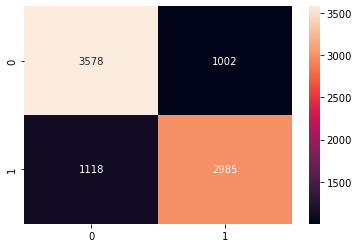

In [34]:
sns.heatmap(confusion_matrix(y_test, pred_lr_tfidf), annot=True, fmt='d')

### embeddings from language model

In [35]:
lr_pretrained = LogisticRegression(penalty="l1", solver="liblinear", random_state=0)
lr_pretrained.fit(X_train_pretrained, y_train)
pred_lr_pretrained = lr_pretrained.predict(X_test_pretrained)
print(classification_report(pred_lr_pretrained, y_test))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      4697
           1       0.75      0.77      0.76      3986

    accuracy                           0.77      8683
   macro avg       0.77      0.77      0.77      8683
weighted avg       0.77      0.77      0.77      8683



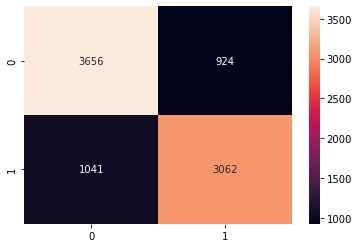

In [36]:
sns.heatmap(confusion_matrix(y_test, pred_lr_pretrained), annot=True, fmt='d');

# test one model with own inputs

In [37]:
example = "Of course, you can have all my money. Why would I need it?!?!?!"
example_vec = cv.transform([example]).toarray()
prediction = lr_cv.predict(example_vec)
encoded_prediction = le.inverse_transform(prediction)
print("prediction: ", prediction)
print("encoded prediction: ", encoded_prediction)

prediction:  [0]
encoded prediction:  ['irony']


# save and load model

In [38]:
model_path = "../artifacts/irony_model.pkl"
model = lr_cv

## save model

In [39]:
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

## load model

In [40]:
with open(model_path, 'rb') as f:
        model = pickle.load(f)